# Segmentación Semántica con U-Net

En este notebook se utiliza una red U-Net con segmentation_models_pytorch (smp), así como el dataset **Penn-Fudan** - https://www.cis.upenn.edu/~jshi/ped_html/?utm_source=chatgpt.com#pub1 para realizar los siguientes pasos:

- Preprocesamiento y data augmentation para segmentación.

- Arquitectura U-Net (encoder-decoder + skip connections) y upsampling/deconvolución (la teoría se explicará en la última clase el lunes 27 de Oct; pero pueden comenzar apoyándose de herramientas para implementarla de una vez).

- Utilización de función de pérdida (p.ej., BCE + Dice), métricas (IoU/Dice)

- Visualización de resultados.

- Buenas prácticas de entrenamiento y validación (overfitting, early stopping, reproducibilidad).

Entrena una U-Net con backbone ResNet34
Calcula Dice Loss + IoU
Muestra resultados visualmente

## Preparar dataset

Es necesario descargar el dataset de https://www.cis.upenn.edu/~jshi/ped_html/?utm_source=chatgpt.com#pub1

El script se encarga de guardar y descomprimir los datos en los paths correspondientes.



In [ ]:
# --- 1️⃣ Crear carpetas base ---
import os

base_dir = "/content/data"
os.makedirs(base_dir, exist_ok=True)

# --- 2️⃣ Subir el archivo PennFudanPed.zip ---
from google.colab import files
print("📁 Sube tu archivo PennFudanPed.zip")
uploaded = files.upload()

# --- 3️⃣ Descomprimir el archivo en /content/data ---
import zipfile

for fname in uploaded.keys():
    zip_path = os.path.join("/content", fname)
    print(f"Descomprimiendo {zip_path} en {base_dir} ...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

print("\n✅ Descompresión completa.")

# --- 4️⃣ Mostrar estructura de carpetas ---
!apt-get install -q tree
!tree /content/data -L 2



📁 Sube tu archivo PennFudanPed.zip



✅ Descompresión completa.
Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/content/data
└── PennFudanPed
    ├── added-object-list.txt
    ├── Annotation
    ├── PedMasks
    ├── PNGImages
    └── readme.txt

4 directories, 2 files


## Configuración general

In [ ]:
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install opencv-python
!pip install matplotlib
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = 'data/PennFudanPed/'
IMAGE_DIR = os.path.join(DATA_DIR, 'PNGImages')
MASK_DIR = os.path.join(DATA_DIR, 'PedMasks')
BATCH_SIZE = 4
EPOCHS = 15
LR = 1e-4
IMG_SIZE = 256

## Dataset y Data Augmentation

In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        # Convertir a binaria: peatón = 1, fondo = 0
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)  # canal único

        return image, mask


# --- Transformaciones ---
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
all_images = sorted([
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.endswith('.png')
])
all_masks = sorted([
    os.path.join(MASK_DIR, f.replace('.png', '_mask.png'))
    for f in os.listdir(IMAGE_DIR)
    if f.endswith('.png')
])

print(f"Total imágenes: {len(all_images)}, Total máscaras: {len(all_masks)}")

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

train_dataset = PennFudanDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = PennFudanDataset(val_imgs, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Total imágenes: 170, Total máscaras: 170


## Modelo U-Net

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

## Función de pérdida y optimizador

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Métrica (IoU)

In [ ]:
from segmentation_models_pytorch import utils as smp_utils

metric = smp_utils.metrics.IoU(threshold=0.5)


## Entrenamiento

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validación ---
    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            val_loss += loss_fn(outputs, masks).item()
            val_iou += metric(outputs, masks).item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"IoU: {val_iou/len(val_loader):.4f}")


Epoch [1/15] | Train Loss: 0.5698 | Val Loss: 0.5264 | IoU: 0.4599
Epoch [2/15] | Train Loss: 0.4450 | Val Loss: 0.4446 | IoU: 0.5669
Epoch [3/15] | Train Loss: 0.3882 | Val Loss: 0.3915 | IoU: 0.6489
Epoch [4/15] | Train Loss: 0.3438 | Val Loss: 0.3526 | IoU: 0.6973
Epoch [5/15] | Train Loss: 0.3089 | Val Loss: 0.3250 | IoU: 0.7043
Epoch [6/15] | Train Loss: 0.2819 | Val Loss: 0.2969 | IoU: 0.7250
Epoch [7/15] | Train Loss: 0.2546 | Val Loss: 0.2699 | IoU: 0.7521
Epoch [8/15] | Train Loss: 0.2314 | Val Loss: 0.2680 | IoU: 0.7420
Epoch [9/15] | Train Loss: 0.2134 | Val Loss: 0.2417 | IoU: 0.7636
Epoch [10/15] | Train Loss: 0.1884 | Val Loss: 0.2315 | IoU: 0.7618
Epoch [11/15] | Train Loss: 0.1772 | Val Loss: 0.2207 | IoU: 0.7578
Epoch [12/15] | Train Loss: 0.1621 | Val Loss: 0.2059 | IoU: 0.7741
Epoch [13/15] | Train Loss: 0.1491 | Val Loss: 0.1919 | IoU: 0.7741
Epoch [14/15] | Train Loss: 0.1399 | Val Loss: 0.1835 | IoU: 0.7742
Epoch [15/15] | Train Loss: 0.1307 | Val Loss: 0.1834 | I

## Visualización de resultados

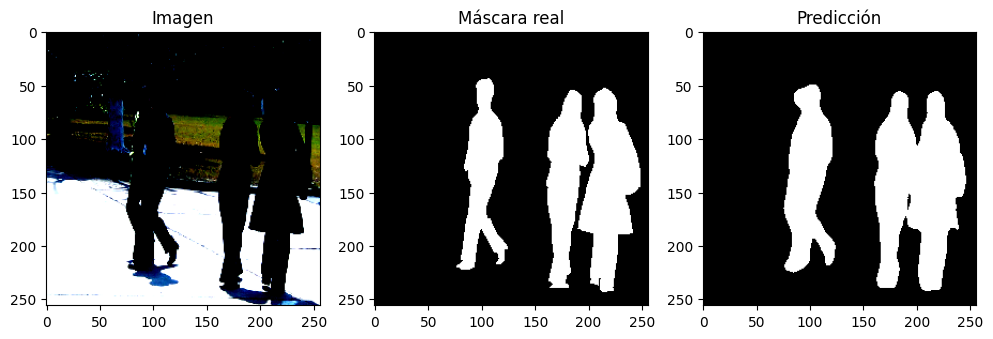

In [ ]:
def visualize_sample(model, dataset, idx=0):
    model.eval()
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0][0].cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(np.moveaxis(img.numpy(), 0, -1)); plt.title("Imagen")
    plt.subplot(1,3,2); plt.imshow(mask[0], cmap='gray'); plt.title("Máscara real")
    plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='gray'); plt.title("Predicción")
    plt.show()


visualize_sample(model, val_dataset, idx=9)